In [61]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration, plot_regression_calibration_curve

# Bikes Data

Poisson

In [157]:
bikes = pd.read_csv('deep_uncertainty/data/bikes/hour.csv')
bikes = bikes[:1000]

In [158]:
X = bikes.iloc[:,:-1]
X = X.drop(['dteday', 'instant'], axis=1)
mask = np.random.rand(len(bikes)) < 0.8
df_train = bikes[mask]
df_test = bikes[~mask]

expr = "cnt ~ " + " + ".join(bikes.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [168]:
y_preds = poisson_training_results.mu
posterior_predictive = poisson(mu=y_preds)

In [172]:
bikes['cnt'].mean()

58.304

In [174]:
bikes['cnt'].std()

50.985557867999354

In [163]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.4375485465363925

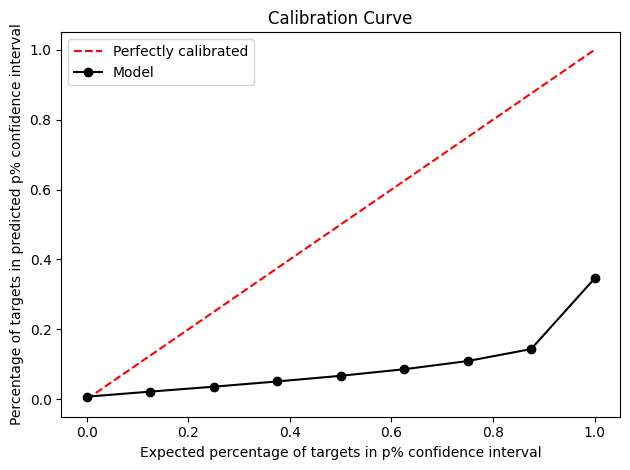

In [164]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

# News Data

Poisson

In [137]:
news = pd.read_csv('deep_uncertainty/data/news/OnlineNewsPopularity.csv')
news = news.drop(labels = "url", axis = 1)
news.rename(columns = lambda x: x.strip(), inplace = True)

mask = np.random.rand(len(news)) < 0.8
df_train = news[mask]
df_test = news[~mask]

expr = "shares ~ " + " + ".join(news.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [110]:
y_preds = poisson_training_results.mu
posterior_predictive = poisson(mu=y_preds)
posterior_predictive
len(y_preds)

31637

In [20]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.34470697613399937

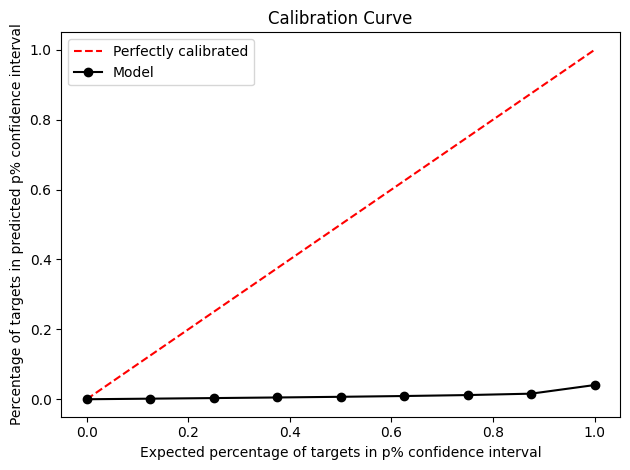

In [69]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

# Negative Binomial

In [111]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['shares'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/2371198126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/2371198126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['shares'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/237119812

In [112]:
successes


0        6.979349
11       7.153866
21       6.802749
22       7.160006
24       6.991454
           ...   
39615    8.092649
39623    7.779368
39627    7.561783
39636    8.570118
39637    7.583477
Length: 8007, dtype: float64

In [113]:
y_preds = predicted_counts
y_test = y_test['shares']
# n is # of successes
n = successes
# p is the probability of success
p = successes / n
posterior_predictive = nbinom(p=p, n=n)
len(y_preds)

8007

In [117]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.33333333333333337

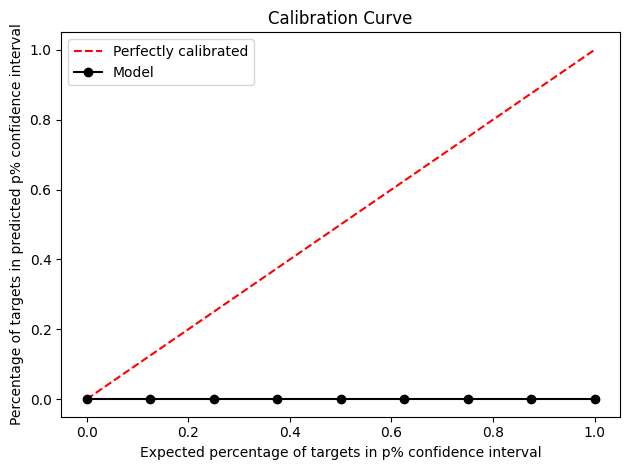

In [118]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

# Traffic Data

Poisson

In [130]:
data = pd.read_csv('deep_uncertainty/data/traffic/Metro_Interstate_Traffic_Volume.csv')
# how to break up the date time into year, month, day, hour
data['date_time'] = pd.to_datetime(data['date_time'])
data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month
data['day'] = data['date_time'].dt.day
data['hour'] = data['date_time'].dt.hour
data.drop('date_time', axis=1, inplace=True)
# enconde all the categorical variables
le = preprocessing.LabelEncoder()
for column in data.columns:
    if data[column].dtype == type(object):
        data[column] = le.fit_transform(data[column].astype(str))
data.rename(columns = lambda x: x.strip(), inplace = True)

mask = np.random.rand(len(data)) < 0.8
df_train = data[mask]
df_test = data[~mask]

expr = "traffic_volume ~ " + " + ".join(data.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

y_preds = poisson_training_results.mu
posterior_predictive = poisson(mu=y_preds)
posterior_predictive
len(y_preds)

traffic_volume    3222.021536
dtype: float64

In [26]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.347480321449666

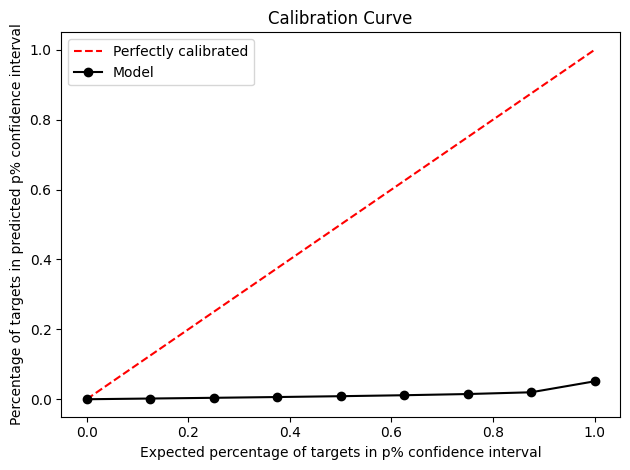

In [71]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [87]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['traffic_volume'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']
predictions_summary_frame

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/1857528728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/1857528728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['traffic_volume'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/1

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,6718.489528,17.021896,6685.209922,6751.934803
6,6781.877849,18.826561,6745.078668,6818.877795
9,4762.784075,12.727026,4737.904769,4787.794025
10,2787.539016,7.249396,2773.366612,2801.783844
15,743.930208,2.008962,740.003117,747.878139
...,...,...,...,...
48183,739.691716,2.046832,735.690859,743.714331
48185,1016.411188,2.692214,1011.148218,1021.701552
48186,1456.132241,3.712553,1448.873921,1463.426923
48190,4157.074171,10.751112,4136.055694,4178.199459


In [88]:
y_preds = predicted_counts
y_test = y_test['traffic_volume']
# n is # of successes
n = aux_olsr_results.params[0]
p = y_preds
# p is the probability of success
posterior_predictive = nbinom(p=p, n=n)
len(y_preds)

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_76104/2663672480.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = aux_olsr_results.params[0]


9698

In [89]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.3334380860697682

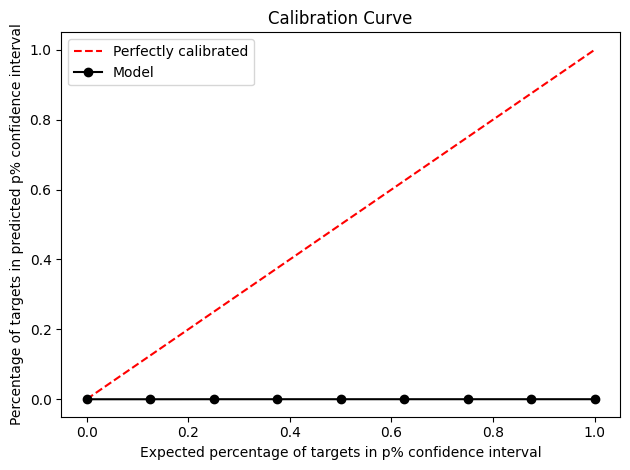

In [90]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)